In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
import seaborn as sns
import sncosmo
import pickle as pk
from sncosmo.salt2utils import BicubicInterpolator
from scipy.interpolate import InterpolatedUnivariateSpline as Spline1d
import astropy.units as u
import astropy.constants as const
from astropy.table import Table

H_ERG_S = const.h.cgs.value
C_AA_PER_S = const.c.to(u.AA / u.s).value
HC_ERG_AA = H_ERG_S * C_AA_PER_S
_SCALE_FACTOR = 1e-12

sns.set_theme()
sns.set(font_scale=1.3)

%matplotlib inline

## covariance graph

In [2]:
output_result_path = './cosmo_results/'

In [3]:
salt2_fit = pd.read_csv('./cosmo_results/fit_salt2.dat',
                       sep='\s+',
                       names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'c', 'c_err', 'mwebv', 'cov_x0x1', 'cov_x0c', 'cov_x1c', 'chiquad/dof', 'model'])
salt2_fit.head()

,name,redshift,t0,t0_err,x0,x0_err,x1,x1_err,c,c_err,mwebv,cov_x0x1,cov_x0c,cov_x1c,chiquad/dof,model
0,03D1au,0.5043,52909.7,0.184387,0.000011,8.286350e-08,1.292900,0.134236,-0.020352,0.012490,0.0296,-6.719740e-09,-2.978810e-10,-0.000203,1.02367,salt2
1,03D1aw,0.5820,52898.4,1.978770,0.000007,1.725990e-07,2.224940,0.707499,-0.007330,0.025483,0.0252,6.354680e-08,-8.085340e-10,0.006636,1.40655,salt2
2,03D1ax,0.4960,52916.1,0.101686,0.000011,9.210410e-08,-0.840369,0.104929,-0.030900,0.013322,0.0264,-5.879210e-09,-4.059190e-10,-0.000103,2.01389,salt2
3,03D1bp,0.3470,52920.3,0.103574,0.000019,2.085140e-07,-1.000660,0.114909,-0.006048,0.008554,0.0236,-1.869040e-08,-1.293780e-09,0.000409,3.73040,salt2
4,03D1co,0.6790,52954.4,0.451643,0.000004,1.590080e-07,0.769722,0.522152,-0.033253,0.042096,0.0299,-7.236470e-08,-1.714290e-09,0.008467,1.37515,salt2


In [4]:
exp3_fit_nocov = pd.read_csv('./cosmo_results/matern_fit_exp3_nocov.dat',
                        sep='\s+',
                        names = ['name', 'redshift', 't0', 't0_err', 'x0', 'x0_err', 'x1', 'x1_err', 'x2', 'x2_err', 'mwebv', 'cov_x0x1', 'cov_x0x2', 'cov_x1x2', 'chiquad/dof', 'model'])
exp3_fit_nocov.head()

,name,redshift,t0,t0_err,x0,x0_err,x1,x1_err,x2,x2_err,mwebv,cov_x0x1,cov_x0x2,cov_x1x2,chiquad/dof,model
0,03D1au,0.5043,52910.6,2.470730e-01,0.000030,6.132440e-07,0.254633,0.087649,-0.496415,0.116260,0.0296,5.039030e-08,6.830020e-08,0.009411,1.45727,exp3
1,03D1aw,0.5820,52899.3,6.017220e-09,0.000013,2.566260e-06,-1.097120,1.047310,-2.507690,1.601010,0.0252,2.676560e-06,4.095260e-06,1.667330,8.93582,exp3
2,03D1ax,0.4960,52916.5,3.381900e-05,0.000024,5.134450e-07,-0.911936,0.117513,-0.486852,0.134829,0.0264,5.082640e-08,6.352980e-08,0.010819,11.36370,exp3
3,03D1bp,0.3470,52919.3,6.073800e-05,0.000047,4.344940e-07,0.205477,0.050134,0.400482,0.064642,0.0236,1.561450e-08,2.265380e-08,0.001901,44.11520,exp3
4,03D1co,0.6790,52950.9,3.881430e-04,0.000010,8.350480e-07,0.541752,0.341222,-0.390626,0.484815,0.0299,2.674550e-07,3.902590e-07,0.159379,7.01169,exp3


In [5]:
exp3_fit_nocov = exp3_fit_nocov[exp3_fit_nocov['chiquad/dof']<5.]
exp3_fit_nocov = exp3_fit_nocov[np.abs(exp3_fit_nocov['x1'])<3.]
exp3_fit_nocov = exp3_fit_nocov[np.abs(exp3_fit_nocov['x2'])<3.]


salt2_fit = salt2_fit[salt2_fit['chiquad/dof']<5.]
salt2_fit = salt2_fit[np.abs(salt2_fit['x1'])<3.]
salt2_fit = salt2_fit[np.abs(salt2_fit['c'])<3.]

In [6]:
commom_sns = list(set(exp3_fit_nocov['name']).intersection(salt2_fit['name']))

In [7]:
covariance_graph_dictionary = {'mag_x0_salt2':[], 'mag_x0_exp3':[],
                               'x1_salt2':[], 'x1_exp3':[],
                               'x2_salt2':[], 'x2_exp3':[]}

In [8]:
for i in range(0, len(commom_sns)):
    salt2_sn_data = salt2_fit[salt2_fit['name']==commom_sns[i]]
    exp3_sn_data = exp3_fit_nocov[exp3_fit_nocov['name']==commom_sns[i]]

    covariance_graph_dictionary['mag_x0_salt2'].append(float(2.5*np.log10(salt2_sn_data['x0'])))
    covariance_graph_dictionary['mag_x0_exp3'].append(float(2.5*np.log10(exp3_sn_data['x0'])))
    
    covariance_graph_dictionary['x1_salt2'].append(float(salt2_sn_data['x1']))
    covariance_graph_dictionary['x1_exp3'].append(float(exp3_sn_data['x1']))

    covariance_graph_dictionary['x2_salt2'].append(float(salt2_sn_data['c']))
    covariance_graph_dictionary['x2_exp3'].append(float(exp3_sn_data['x2']))

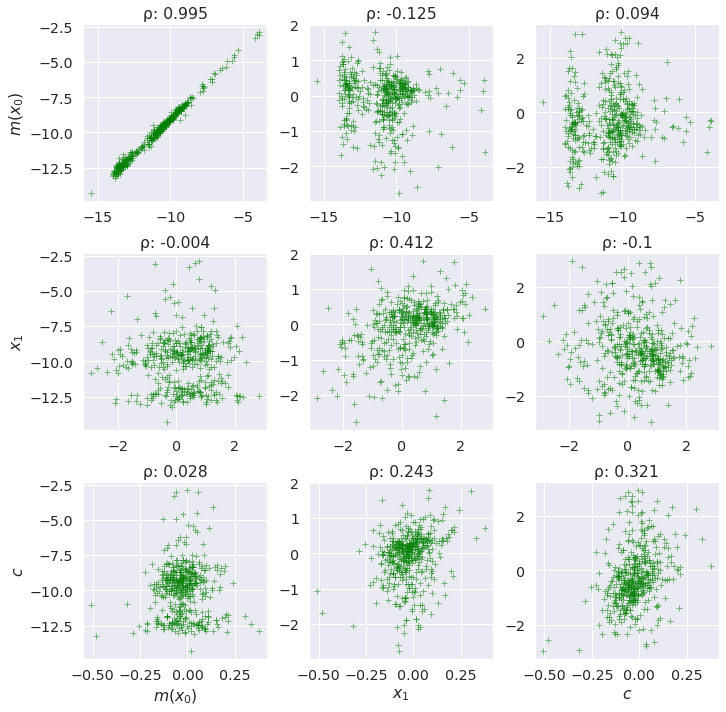

In [9]:
variables = ['mag_x0', 'x1', 'x2']
latex_variables_exp = ['$m(x_0)$', '$x_1$', '$x_2$']
latex_variables_salt2 = ['$m(x_0)$', '$x_1$', '$c$']

#sns.set(font_scale=1.3) 
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(0, len(ax)):
    for j in range(0, len(ax[0])):
        pearsoncoeff = str(round(pearsonr(np.array(covariance_graph_dictionary[variables[i]+'_salt2']), np.array(covariance_graph_dictionary[variables[j]+'_exp3']))[0], 3))
        ax[i][j].plot(covariance_graph_dictionary[variables[i]+'_salt2'], covariance_graph_dictionary[variables[j]+'_exp3'], '+', c='green', alpha=.5)
        ax[i][j].set_title('ρ: '+pearsoncoeff)
        
        if j==0:
            ax[i][j].set_ylabel(latex_variables_salt2[i])
        if i==2:
            ax[i][j].set_xlabel(latex_variables_salt2[j])
        
fig.tight_layout()
fig.savefig('./images/pearsoncoeffs.png', dpi=300)

## Light curve fit

In [10]:
M0_salt2 = pd.read_csv("./SALT2_templates/salt2_template_0.dat", names=["time", "wave", "flux"], sep="\s+")
M1_salt2 = pd.read_csv("./SALT2_templates/salt2_template_1.dat", names=["time", "wave", "flux"], sep="\s+")
c = pd.read_csv("./SALT2_templates/salt2_colour_law_guy2010.dat", header = None, sep = "\s+") # color term
c.columns = ["wave", "ext"]
c.head()

,wave,ext
0,3000,4.44356
1,3010,4.35652
2,3020,4.27089
3,3030,4.18667
4,3040,4.10384


In [11]:
fa_path = './PCA_FA_components/FA/'
fa = pk.load(open(fa_path+'fa.pkl','rb'))

/home/joao/.local/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator FactorAnalysis from version 1.0.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
# phase (x) and wavelength (y)
gridx = np.linspace(-8, 48, 48+8+1, dtype=int) # in days
gridy = np.linspace(3500, 8300, int((8300-3500)/10+1), dtype=int) # in Angstroms

M = []
for i in range(0, len(fa.components_)):
    M.append(fa.components_[i].reshape(len(gridy), len(gridx)).T)

In [13]:
# A new class for sncosmo
class EXP_LC(sncosmo.Source):
    
    _param_names = ['x0', 'x1', 'x2','x3','x4','x5','x6','x7','x8','x9', 'c']
    param_names_latex = ['x_0', 'x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'c']
    
    def __init__(self, phase, wave, flux0, flux1, flux2, flux3, flux4, flux5, flux6, flux7, flux8, flux9, LC, name='EXP', version='2021'):

        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        
        self._model_flux0  = BicubicInterpolator(phase, wave, flux0*_SCALE_FACTOR)
        self._model_flux1  = BicubicInterpolator(phase, wave, flux1*_SCALE_FACTOR)
        self._model_flux2  = BicubicInterpolator(phase, wave, flux2*_SCALE_FACTOR)
        self._model_flux3  = BicubicInterpolator(phase, wave, flux3*_SCALE_FACTOR)
        self._model_flux4  = BicubicInterpolator(phase, wave, flux4*_SCALE_FACTOR)
        self._model_flux5  = BicubicInterpolator(phase, wave, flux5*_SCALE_FACTOR)
        self._model_flux6  = BicubicInterpolator(phase, wave, flux6*_SCALE_FACTOR)
        self._model_flux7  = BicubicInterpolator(phase, wave, flux7*_SCALE_FACTOR)
        self._model_flux8  = BicubicInterpolator(phase, wave, flux8*_SCALE_FACTOR)
        self._model_flux9  = BicubicInterpolator(phase, wave, flux9*_SCALE_FACTOR)
        self._model_ext =  Spline1d(LC['wave'], LC['ext'],  k=1)  

        self._parameters = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])  # initial guess
        
    def _flux(self, phase, wave):
        x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, c = self._parameters
        #print('flux!')
        return x0 * (self._model_flux0(phase, wave) +  x1 * self._model_flux1(phase, wave) +  x2 * self._model_flux2(phase, wave) +  x3 * self._model_flux3(phase, wave) +  x4 * self._model_flux4(phase, wave)  +  x5 * self._model_flux5(phase, wave) +  x6 * self._model_flux6(phase, wave) +  x7 * self._model_flux7(phase, wave) +  x8 * self._model_flux8(phase, wave) +  x9 * self._model_flux9(phase, wave))* 10.** (-0.4 * self._model_ext(wave) * c)
   
    def _bandflux_rvar_single(self, band, phase):
        print('single')
        x0 = self._parameters[0]
        x1 = self._parameters[1]
        x2 = self._parameters[2]

        wave, dwave = band.minwave()+(band.maxwave() - band.minwave())/2, 10.
        trans = band(wave) # transmission
        
        m0 = self._model_flux0(phase, wave)
        m1 = self._model_flux1(phase, wave)
        m2 = self._model_flux2(phase, wave)
        tmp = trans * wave
            
        m0int = np.sum(m0 * tmp, axis=1) * dwave/HC_ERG_AA
        m1int = np.sum(m1 * tmp, axis=1) * dwave/HC_ERG_AA
        m2int = np.sum(m2 * tmp, axis=1) * dwave/HC_ERG_AA
        return ((m0int+x1*m1int+x2*m2int)*0.008083732930093502)**2 + (m1int*x0*0.2617690714197349)**2 + (m2int*x0*0.34451843421019135)**2

    # teste
    def bandflux_rcov(self, band, phase):
        print('rcov')
        diagonal = np.zeros(phase.shape, dtype=np.float64)
        for b in set(band):
            mask = band == b
            diagonal[mask] = self._bandflux_rvar_single(b, phase[mask])
            
        return np.diagflat(diagonal)

In [14]:
 exp_lc = EXP_LC(gridx, gridy, M[0], M[1], M[2], M[2], M[2], M[2], M[2], M[2], M[2], M[2], c)

In [15]:
sn_imput_name = 'sn2007ae'

In [16]:
data = sncosmo.read_lc('./JLA/lc-'+sn_imput_name+'.list', format='salt2')

In [17]:
snname = data.meta['SN']
print(snname)
exp3 = sncosmo.Model(source=exp_lc,
                     effects=[sncosmo.F99Dust()],
                     effect_names=['mw'],
                     effect_frames=['obs'])


exp3.set(mwebv=data.meta['MWEBV'],
         z = data.meta['Z_HELIO'],
         x3 = 0,
         x4 = 0,
         x5 = 0,
         x6 = 0,
         x7 = 0,
         x8 = 0,
         x9 = 0,
         c = 0)

result_exp3, m_exp3 = sncosmo.fit_lc(data, exp3, ['t0', 'x0', 'x1', 'x2'], modelcov=True, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)


salt2 = sncosmo.Model(source='salt2',
                     effects=[sncosmo.F99Dust()],
                     effect_names=['mw'],
                     effect_frames=['obs'])
salt2.set(mwebv=data.meta['MWEBV'],
          z = data.meta['Z_HELIO'])
result_salt2, m_salt2 = sncosmo.fit_lc(data, salt2, ['t0', 'x0', 'x1', 'c'], modelcov=True, phase_range=(-8, 48.), wave_range=(3500., 8300.), verbose=False)


/home/joao/.local/lib/python3.8/site-packages/sncosmo/fitting.py:187: RuntimeWarning: Dropping following bands from data: keplercam::i, keplercam::b(out of model wavelength range)
  warnings.warn("Dropping following bands from data: " +


sn2007ae
rcov
single
single


In [18]:
data=Table.from_pandas(data.to_pandas()[(data['Filter']=='KEPLERCAM::r') | (data['Filter']=='KEPLERCAM::V')])

In [19]:
result_salt2.parameters[1]

54153.35328830002

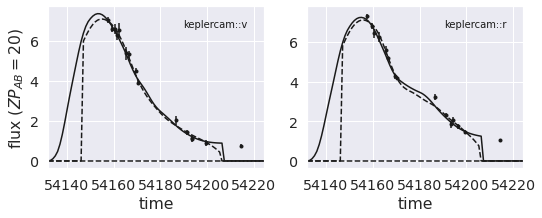

In [20]:
fig = sncosmo.plot_lc(data=data,
                      model=[m_salt2, m_exp3],
                      errors=[result_salt2.errors, result_exp3.errors],
                      color='k',
                      zp=20); 

In [21]:
fig.axes[0].set_xlim(result_salt2.parameters[1]-6.5, result_salt2.parameters[1]+50)
fig.axes[0].set_xlabel('p (days)')
fig.axes[1].set_xlim(result_salt2.parameters[1]-6.5, result_salt2.parameters[1]+50)
fig.axes[1].set_xlabel('p (days)');

In [24]:
fig.savefig('./images/'+sn_imput_name, dpi=250)